In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import MAPInference as mapi
from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
df = pp.load_session_db(dir="E:\\")
# df = pp.load_session_db()
df = df[df['RewardCount']>20]
# df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']

In [4]:
getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorph = lambda s: (xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))

def trial_info_to_morph(trial_info):
    wall = trial_info['morphs']+trial_info['wallJitter']
    bckgnd = trial_info['morphs']+trial_info['bckgndJitter']
    tower = np.minimum(np.maximum(trial_info['morphs']+trial_info['towerJitter'],0),1)

    return np.concatenate((wallmorph(wall)[:,np.newaxis],wall[:,np.newaxis],bckgnd[:,np.newaxis],tower[:,np.newaxis]),axis=1)
    
def single_session_data(sess):
    
    VRDat = pp.behavior_dataframe(sess["data file"])
    trial_info, tstarts_, teleports_ = u.by_trial_info(VRDat)
    
    return trial_info_to_morph(trial_info)

def single_mouse_data(mouse):
    df_mouse = df[df["MouseName"]==mouse]
    data = {}
    for i in range(1,df_mouse.shape[0]):
        sess = df_mouse.iloc[i]
        date, num = sess['DateFolder'],sess['SessionNumber']
        key = date + str(num) 
        
        data[key] = single_session_data(sess)
        
    return data

def single_mouse_em_all(mouse,data = None):
    if data is None:
        data = single_mouse_data(mouse)
    else:
        pass
    
    for i, (key,arr) in enumerate(data.items()):
        if i == 0:
            em_all = arr
        else:
            em_all = np.concatenate((em_all,arr),axis=0)
    return em_all

def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)


In [5]:
for m, mouse in enumerate(mice):
    print(mouse)
    if m ==0:
        EM_all = single_mouse_em_all(mouse)
    else:
        EM_all = np.concatenate((EM_all,single_mouse_em_all(mouse)),axis=0)
    
        



4139265.3


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


4139265.4
4139265.5
4222168.1
deleting last index from trial start
deleting last index from trial start
4343703.1
4343706
4222153.1
4222153.2
4222153.3
4222174.1
4222154.1
4343702.1


[166.84879104  14.46515158]
(2, 2)
(27008, 2)
[[-0.76856913 -0.63976675]
 [ 0.63976675 -0.76856913]]


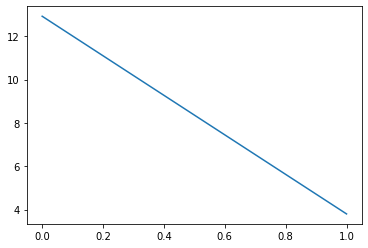

In [81]:
u_,s_,vh_ = np.linalg.svd(EM_all[:,:2],full_matrices=False)

print(s_)
print(vh_.shape)
print(u_.shape)
print(vh_)

f,ax = plt.subplots()
ax.plot(s_**.5)
# vh_norm = -1*vh_
vh_norm = vh_/vh_.sum(axis=1,keepdims=True)

In [18]:
em_all = single_mouse_em_all('4139265.5')

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [19]:
print(np.amax(em_all,axis=0))

[1.10006025 1.09968958 1.09984372 1.        ]


In [117]:
# em_all1d =  np.dot(em_all[:,:2],vh_norm[0,:].T)
em_all1d = em_all[:,0]

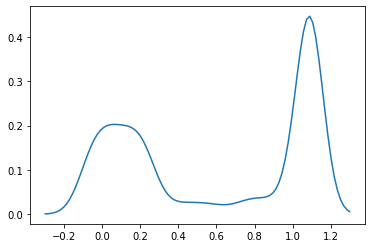

In [118]:
x = np.linspace(-.3,1.3,num=100)
y = 0*x
N = em_all1d.shape[0]
for i,m in enumerate(em_all1d.tolist()):
    y+=gaussian(m,.1,x)/N
    
f,ax = plt.subplots()
ax.plot(x,y)

(1.1, -0.1)

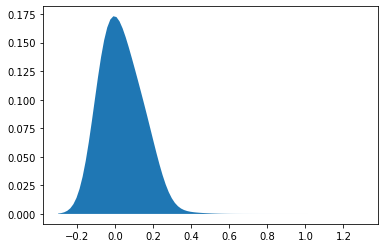

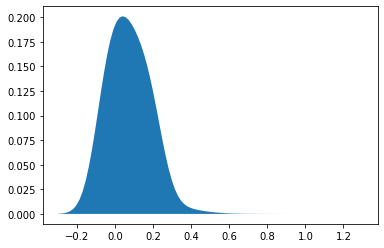

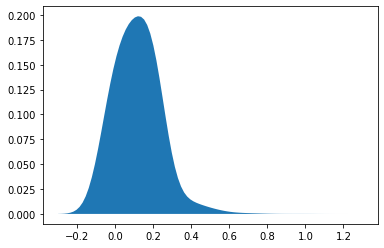

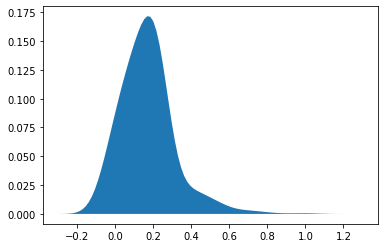

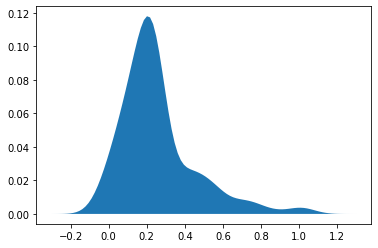

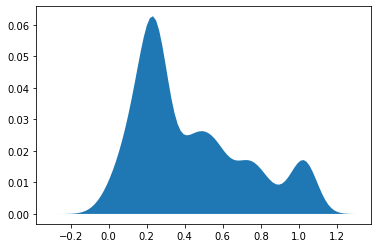

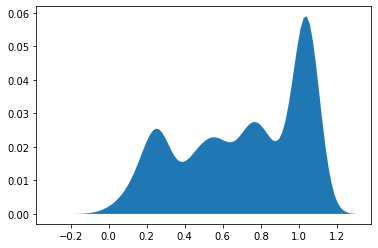

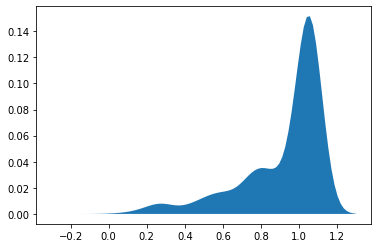

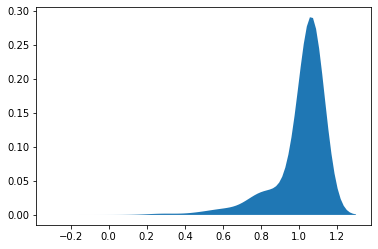

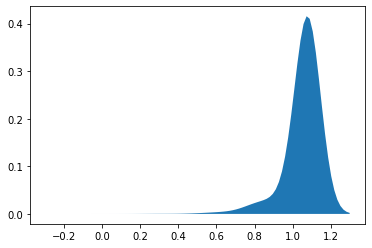

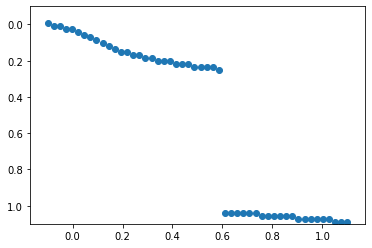

In [126]:
mus = np.linspace(-.1,1.1)
shat = np.zeros(mus.shape)
for i,s in enumerate(mus):
    l = gaussian(s,.3,x)
#     l=l/l.sum()
    post = l*y
    
    shat[i] = x[np.argmax(post)]
    if i%5==0:
        f,ax = plt.subplots()
        ax.fill_between(x,post)
    
f,ax = plt.subplots()
ax.scatter(mus,shat)
ax.set_ylim([1.1,-.1])

# Try new method on some neural data

In [7]:
df_mouse = df[df["MouseName"]=='4139265.5']
df_mouse = df_mouse[df_mouse['Imaging']==1]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanmat,s2pfolder
1410,4139265.5,10_02_2019,1,TwoTower_foraging,60,1,CA1,2019-02-10,E:\VR_Data\TwoTower\4139265.5\10_02_2019\TwoTo...,None,None
1412,4139265.5,10_02_2019,3,TwoTower_foraging,60,1,CA1,2019-02-10,E:\VR_Data\TwoTower\4139265.5\10_02_2019\TwoTo...,None,None
1439,4139265.5,12_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-12,E:\VR_Data\TwoTower\4139265.5\12_02_2019\TwoTo...,None,None
1462,4139265.5,15_02_2019,2,TwoTower_foraging,86,1,CA1,2019-02-15,E:\VR_Data\TwoTower\4139265.5\15_02_2019\TwoTo...,None,None
1481,4139265.5,17_02_2019,2,TwoTower_foraging,80,1,CA1,2019-02-17,E:\VR_Data\TwoTower\4139265.5\17_02_2019\TwoTo...,None,None
1501,4139265.5,19_02_2019,2,TwoTower_foraging,97,1,CA1,2019-02-19,E:\VR_Data\TwoTower\4139265.5\19_02_2019\TwoTo...,None,None
1519,4139265.5,21_02_2019,2,TwoTower_foraging,105,1,CA1,2019-02-21,E:\VR_Data\TwoTower\4139265.5\21_02_2019\TwoTo...,None,None
1528,4139265.5,22_02_2019,2,TwoTower_foraging,98,1,CA1,2019-02-22,E:\VR_Data\TwoTower\4139265.5\22_02_2019\TwoTo...,None,None
1534,4139265.5,23_02_2019,2,TwoTower_foraging,96,1,CA1,2019-02-23,E:\VR_Data\TwoTower\4139265.5\23_02_2019\TwoTo...,None,None
1539,4139265.5,24_02_2019,2,TwoTower_foraging,90,1,CA1,2019-02-24,E:\VR_Data\TwoTower\4139265.5\24_02_2019\TwoTo...,None,None


In [66]:
sess = df_mouse.iloc[-1]
sess['scanmat']=pp.build_2P_filename(sess,serverDir = "D:\\2P_Data\\TwoTower")
sess['s2pfolder']=pp.build_s2p_folder(sess,serverDir = "D:\\2P_Data\\TwoTower")
sess

C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


MouseName                                                4139265.5
DateFolder                                              24_02_2019
SessionNumber                                                    2
Track                                            TwoTower_foraging
RewardCount                                                     90
Imaging                                                          1
ImagingRegion                                                  CA1
DateTime                                       2019-02-24 00:00:00
data file        E:\VR_Data\TwoTower\4139265.5\24_02_2019\TwoTo...
scanmat          D:\2P_Data\TwoTower\4139265.5\24_02_2019\TwoTo...
s2pfolder        D:\2P_Data\TwoTower\4139265.5\24_02_2019\TwoTo...
Name: 1539, dtype: object

In [67]:
VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=.7)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,
                                            VRDat['pos']._values,tstart_inds,
                                            teleport_inds,bin_size=10,
                                            speed = VRDat['speed']._values)
S_trial_mat[np.isnan(S_trial_mat)]=0

num aberrant ttls 0.0


C:\Users\markp\anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


frame diff 0


In [71]:
rmask = trial_info['rewards']==0
S_trial_mat[np.isnan(S_trial_mat)]=0
# S_trial_mat is trials x positions x neurons
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,1,axis=1) # smooth position by 1 bin

#flatten to be trial x positions*neurons
S_tmat = np.reshape(S_trial_mat,[S_trial_mat.shape[0],-1])
# divide trials by l2-norm
S_tmat = S_tmat/np.linalg.norm(S_tmat,ord=2,axis=-1)[:,np.newaxis]
# outer product give trial x trial cosine similarity
S_t_rmat = np.matmul(S_tmat,S_tmat.T)
# ensure that this is positive (should be true if using deconvolved rate)
print("negative similarity inds:", (S_t_rmat<0).ravel().sum())

# plot results
# f_stsm,axtup_stsm = sm.plot_trial_simmat(S_t_rmat,trial_info)



negative similarity inds: 0


In [127]:
# plot similarity fraction
morphmat = trial_info_to_morph(trial_info)
wallMorph = morphmat[:,0]
effMorph = np.dot(trial_info_to_morph(trial_info)[:,:2],vh_norm[0,:].T)
sf = np.zeros(effMorph.shape) # similarity fraction
for trial in range(effMorph.shape[0]): # for each trial
    # get masks for centroids
    mask0 = trial_info['morphs']==0
    mask1 = trial_info['morphs']==1
    # if current trial is in mask, exclude it
    if trial_info['morphs'][trial]==0:
        mask0[trial]=False
    elif trial_info['morphs'][trial]==1:
        mask1[trial]=False

    # calculate centroids
    centroid0, centroid1 = np.nanmean(S_tmat[mask0,:],axis=0), np.nanmean(S_tmat[mask1,:],axis=0)
    centroid0/np.linalg.norm(centroid0,ord=2)
    centroid1/np.linalg.norm(centroid1,ord=2)

    # similarity to two centroids
    angle0,angle1 = np.dot(S_tmat[trial,:],centroid0),np.dot(S_tmat[trial,:],centroid1)
    # whole trial similarity fraction
    sf[trial] = angle0/(angle0+angle1)

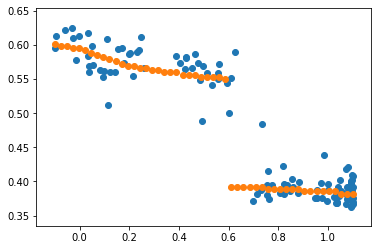

In [142]:
f,ax = plt.subplots()
ax.scatter(wallMorph,sf)
ax.scatter(mus,.2*(1.1-shat)+.38)

### Confirming recapitualation of Unity planes

In [23]:
# ensure texture looks the same as unity

intens = lambda xs,ys, f, theta: np.cos(2.*np.pi*f*(xs*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) + ys*(np.cos(theta+np.pi/4.)-np.sin(theta+np.pi/4))))


In [26]:
f1,f2 = 2.5,3.5
theta1,theta2 = 60.,10.
morph = 1.
f = morph*f1 + (1-morph)*f2
print(f)
theta = (morph*theta1  + (1-morph)*theta2) * np.pi / 180
print(theta)
texture = np.zeros([120,1500])
for y in range(texture.shape[1]):
    for x in range(texture.shape[0]):
        xs = x/texture.shape[1]*1
        ys = y/texture.shape[0]*1
        texture[x,y]=intens(xs,ys,f,theta)#+ intens(ys,xs,f,theta)
print(xs,ys)

2.5
1.0471975511965976
0.07933333333333334 12.491666666666667


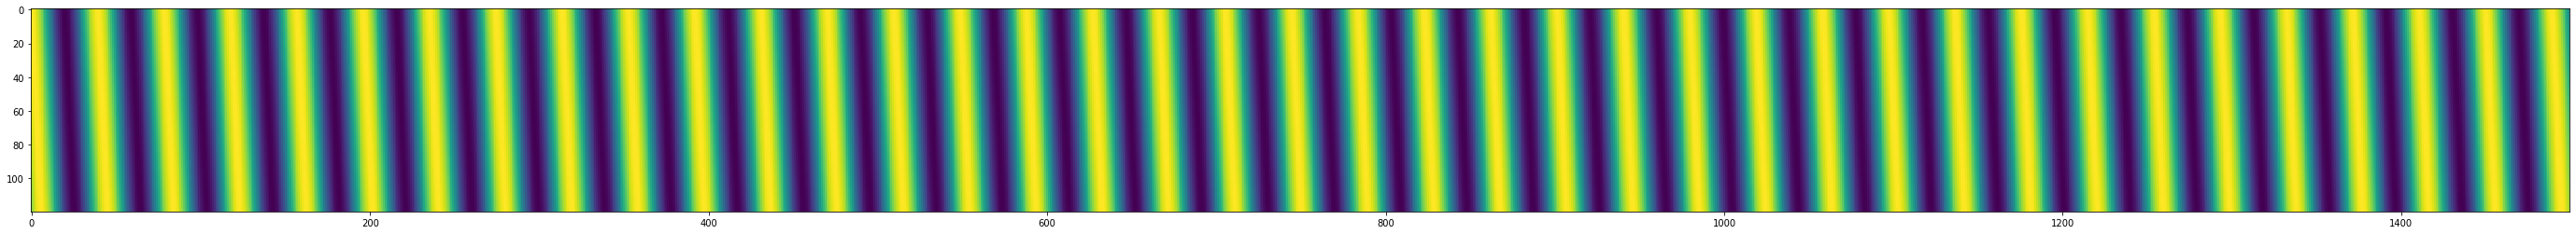

In [27]:
f,ax = plt.subplots(1,1,figsize=[50,4],sharex=True)
ax.imshow(texture)


In [28]:
xfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)-np.sin(theta+np.pi/4.)) 
yfreq = lambda f,theta: f*1500/120*(np.cos(theta + np.pi/4.)+np.sin(theta+np.pi/4.)) 

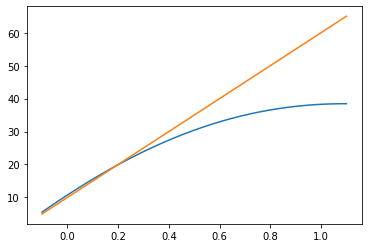

In [29]:
morphs = np.linspace(-.1,1.1,num=1000)
# xcoeff = np.zeros(morphs.shape)
f,theta = morphs*f1 + (1-morphs)*f2, (morphs*theta1  + (1-morphs)*theta2) * np.pi / 180
xcoeff = xfreq(f,theta)
ycoeff = yfreq(f,theta)
fig,ax = plt.subplots()
ax.plot(morphs,np.abs(xcoeff))
# ax.plot(morphs,np.abs(ycoeff))
ang = np.abs(np.arctan(xcoeff/ycoeff)*180/np.pi)
ax.plot(morphs,ang)